In [1]:
import pandas as pd
from elasticsearch import Elasticsearch
import elasticsearch.helpers
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

utc=pytz.UTC

# Elastic search query code: https://stackoverflow.com/a/56094205
es = Elasticsearch('elasticsearch', port=9200)

body={"query": {"match_all": {}}}

# Figure 3 - Issues Count

In [2]:
results = elasticsearch.helpers.scan(es, query=body, index="gitter_enriched_raw")
df_gitter_enriched_raw = pd.DataFrame.from_dict([document['_source'] for document in results])

In [3]:
# Retrieve number of issues referred to in each Gitter message
rows = []

for i,g in df_gitter_enriched_raw.groupby('project'):
    numbers = set()
    issues_count = 0
    repo_type = {
        'repo': i,
        'issues_count': 0,
        'parent': 0,
        'foreign': 0,
        'project': 0
    }
    for i2, g2 in g[g.issues.astype(bool)].iterrows():
        repo_type['issues_count'] += len(g2.issues)
        issues_count += len(g2.issues)
        for item in g2.issues:
            if 'number' in item.keys():
                numbers.add(item['number'])
            if 'repo_type' in item.keys():
                repo_type[item['repo_type']] += 1
                
    rows.append(repo_type)

In [4]:
griomire_lab_issues_count = pd.DataFrame(rows)
griomire_lab_issues_count['short_name'] = griomire_lab_issues_count['repo'].apply(lambda x: x.split('/')[-1])
griomire_lab_issues_count = griomire_lab_issues_count.sort_values(by=['short_name'], key=lambda col: col.str.lower())

In [5]:
# Note: issues_count is the length of "issues" extracted from https://developer.gitter.im/docs/messages-resource
# It can include issues that are not valid
griomire_lab_issues_count

,repo,issues_count,parent,foreign,project,short_name
1,amberframework/amber,669,184,123,282,amber
2,aws/aws-sdk-go,61,0,4,25,aws-sdk-go
5,patchthecode/JTAppleCalendar,144,0,1,82,JTAppleCalendar
4,mailboxer/mailboxer,4,0,0,3,mailboxer
0,PerfectlySoft/Perfect,36,5,4,14,Perfect
3,kriasoft/react-starter-kit,266,16,46,142,react-starter-kit
6,shuup/shuup,56,0,14,27,shuup


In [6]:
# Previous pipeline data
# https://raw.githubusercontent.com/Hareem-E-Sahar/gitter/master/Scripts_Graphs/OUTPUT.csv
columns = ['Repo', 'IssuesFound', 'ParentRepoSame', 'No-of-repo-only-issues', 'ForeignIssues']
previous_pipeline_api_counts = pd.read_csv('previous_pipeline_data/gitter_api_issues.csv')[columns]

In [7]:
# Filter out the repos that are not in our replication with GrimoireLab
previous_pipeline_api_counts = previous_pipeline_api_counts[previous_pipeline_api_counts['Repo'].isin(df_gitter_enriched_raw.project.unique())]
previous_pipeline_api_counts['short_name'] = previous_pipeline_api_counts['Repo'].apply(lambda x: x.split('/')[-1])
previous_pipeline_api_counts = previous_pipeline_api_counts.sort_values(by='short_name', key=lambda col: col.str.lower())

In [8]:
# Note: issues_count is the length of "issues" extracted from https://developer.gitter.im/docs/messages-resource
# It can include issues that are not valid
# There are likely less issuesfound since there are less messages processed in the previous pipeline
# There is also a discrepancy with the repo classification (parent, foreign, project) which may due to the previous project classifying even invalid issues
previous_pipeline_api_counts

,Repo,IssuesFound,ParentRepoSame,No-of-repo-only-issues,ForeignIssues,short_name
0,amberframework/amber,579,403,250,109,amber
3,aws/aws-sdk-go,52,19,19,2,aws-sdk-go
7,patchthecode/JTAppleCalendar,141,79,79,1,JTAppleCalendar
9,mailboxer/mailboxer,4,3,3,0,mailboxer
13,PerfectlySoft/Perfect,36,19,14,4,Perfect
14,kriasoft/react-starter-kit,265,157,141,46,react-starter-kit
16,shuup/shuup,52,23,23,14,shuup


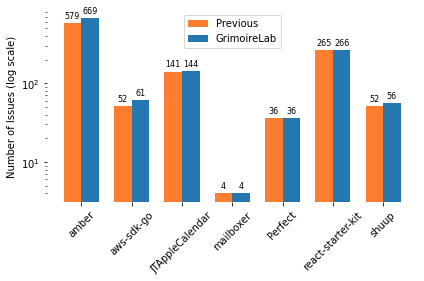

In [9]:
# Create the chart
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

import matplotlib.pyplot as plt
import numpy as np

labels = griomire_lab_issues_count['short_name'].unique()
previous = previous_pipeline_api_counts['IssuesFound'].values
grimoirelab = griomire_lab_issues_count['issues_count'].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, previous, width, label='Previous', color="#fc7c30")
rects2 = ax.bar(x + width/2, grimoirelab, width, label='GrimoireLab', color='#2578af')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Issues (log scale)')
# ax.set_title('Issues from API')
ax.set_xticks(x, labels)
ax.legend(loc='upper center')

ax.bar_label(rects1, padding=3, fontsize=8)
ax.bar_label(rects2, padding=3, fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.yscale("log")
plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig('output/api_counts.pdf')
plt.show()

<hr>

# Figure 4 - Mentioned Issues Resolution Time

In [10]:
# First retrieve all the issues/pull requests referred to in each Gitter message
gitter_issues = {}

for i,g in df_gitter_enriched_raw.groupby('project'):
    gitter_issues[i] = set()
    for i2, g2 in g[g.issues.astype(bool)].iterrows():
        # Retrieve issues in a similar timeline to the previous pipleine
        if pd.to_datetime(g2['grimoire_creation_date']) < datetime(2019, 11, 30).replace(tzinfo=utc):
            for item in g2.issues:
                if 'repo_type' in item.keys() and 'number' in item.keys():
                    if item['repo_type'] == 'project':
                        gitter_issues[i].add(item['number'])

In [11]:
# Query enriched github issues index
results = elasticsearch.helpers.scan(es, query=body, index="github_issues")
df_gitter_issues = pd.DataFrame.from_dict([document['_source'] for document in results])

In [12]:
gitter_issue_rows = []

# We exclude closed pull requests since the previous pipeline does as well
for i,g in df_gitter_issues[(df_gitter_issues['state'] == 'closed') & ~(df_gitter_issues['pull_request'])].groupby('project'):
    for i2, row in g.iterrows():
        if row['id_in_repo'] in gitter_issues[i]:
            # Retrieve issues in a similar timeline to the previous pipleine
            if pd.to_datetime(row['closed_at']) < datetime(2019, 11, 30).replace(tzinfo=utc):
                gitter_issue_rows.append(row)

In [13]:
gitter_issue_df = pd.DataFrame(gitter_issue_rows)

# Previous study used time to close in hours
gitter_issue_df['time_to_close_hours'] = gitter_issue_df['time_to_close_days'] * 24

gitter_issue_df['short_name'] = gitter_issue_df['project'].apply(lambda x: x.split('/')[-1])

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'JTAppleCalendar'),
  Text(2, 0, 'Perfect'),
  Text(3, 0, 'amber'),
  Text(4, 0, 'aws-sdk-go'),
  Text(5, 0, 'mailboxer'),
  Text(6, 0, 'react-starter-kit'),
  Text(7, 0, 'shuup')])

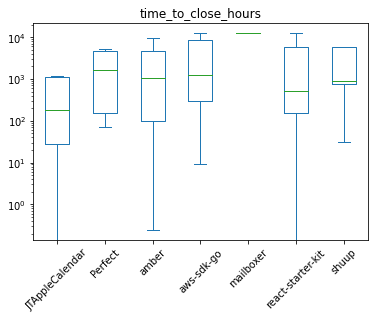

In [14]:
# Preliminary Visualization of GrimoireLab Pipeline
gitter_issue_df.plot.box(column="time_to_close_hours", by="short_name", showfliers=False, logy=True)
plt.xticks(rotation=45)

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'JTAppleCalendar'),
  Text(2, 0, 'Perfect'),
  Text(3, 0, 'amber'),
  Text(4, 0, 'aws-sdk-go'),
  Text(5, 0, 'mailboxer'),
  Text(6, 0, 'react-starter-kit'),
  Text(7, 0, 'shuup')])

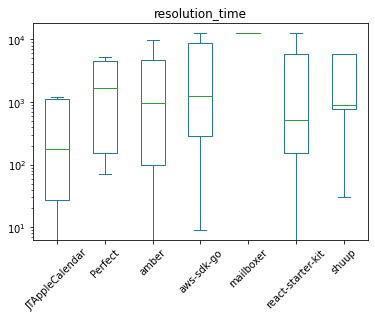

In [15]:
# Previous pipeline resolution time
# https://raw.githubusercontent.com/Hareem-E-Sahar/gitter/master/ResolutionTime_AllGitterBugReports.csv
previous_resolution_time = pd.read_csv('previous_pipeline_data/ResolutionTime_AllGitterBugReports.csv')
previous_resolution_time = previous_resolution_time[previous_resolution_time.resolution_time != 'NA']
previous_resolution_time = previous_resolution_time[~(previous_resolution_time.resolution_time.isnull())]
previous_resolution_time['name'] = previous_resolution_time['room']
previous_resolution_time.loc[previous_resolution_time.room == 'aws', 'name'] = 'aws-sdk-go'
previous_resolution_time.loc[previous_resolution_time.room == 'perfect', 'name'] = 'Perfect'
previous_resolution_time.loc[previous_resolution_time.room == 'react', 'name'] = 'react-starter-kit'
previous_resolution_time = previous_resolution_time[previous_resolution_time.name.isin(gitter_issue_df['short_name'].unique())]
previous_resolution_time.plot.box(column="resolution_time", by="name", showfliers=False, logy=True)
plt.xticks(rotation=45)

## Export Figure 4 data for RScript
We generate the data and use `RScript/resolution_time.R` to generate the plot for our paper

In [16]:
gitter_issue_df[['time_to_close_hours', 'project', 'created_at', 'closed_at', 'id_in_repo', 'short_name']].to_csv('output/grimoire_time_to_close_hours.csv',index=False)
previous_resolution_time.to_csv('output/previous_pipeline_time_to_close_hours.csv',index=False)

## Discrepancy Investigation

We investigate to see if the issues identified overlap for the previous pipeline and Grimoirelab finding that the previous pipleine missed 1 issue

We also determine that Grimoirelab data has more precision for time

### Issue Overlap

In [17]:
issues_jtapplecalendar = previous_resolution_time[previous_resolution_time['name'] == 'JTAppleCalendar']

print(set(issues_jtapplecalendar.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='JTAppleCalendar']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='JTAppleCalendar']['id_in_repo'].astype(int).values) - set(issues_jtapplecalendar.issuenumber.unique()))

set()
set()


In [18]:
issues_Perfect = previous_resolution_time[previous_resolution_time['name'] == 'Perfect']

print(set(issues_Perfect.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='Perfect']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='Perfect']['id_in_repo'].astype(int).values) - set(issues_Perfect.issuenumber.unique()))

set()
set()


In [19]:
issues_amber = previous_resolution_time[previous_resolution_time['name'] == 'amber']

print(set(issues_amber.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='amber']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='amber']['id_in_repo'].astype(int).values) - set(issues_amber.issuenumber.unique()))

# https://github.com/amberframework/amber/issues/1129 was omitted from the previous pipeline

set()
{1129}


In [20]:
issues_aws = previous_resolution_time[previous_resolution_time['name'] == 'aws-sdk-go']

print(set(issues_aws.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='aws-sdk-go']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='aws-sdk-go']['id_in_repo'].astype(int).values) - set(issues_aws.issuenumber.unique()))

set()
set()


In [21]:
issues_mailboxer = previous_resolution_time[previous_resolution_time['name'] == 'mailboxer']

print(set(issues_mailboxer.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='mailboxer']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='mailboxer']['id_in_repo'].astype(int).values) - set(issues_mailboxer.issuenumber.unique()))

set()
set()


In [22]:
issues_mailboxer = previous_resolution_time[previous_resolution_time['name'] == 'react-starter-kit']

print(set(issues_mailboxer.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='react-starter-kit']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='react-starter-kit']['id_in_repo'].astype(int).values) - set(issues_mailboxer.issuenumber.unique()))

set()
set()


In [23]:
issues_shuup = previous_resolution_time[previous_resolution_time['name'] == 'shuup']

print(set(issues_shuup.issuenumber.unique()) - set(gitter_issue_df[gitter_issue_df.short_name=='shuup']['id_in_repo'].astype(int).values))
print(set(gitter_issue_df[gitter_issue_df.short_name=='shuup']['id_in_repo'].astype(int).values) - set(issues_shuup.issuenumber.unique()))

set()
set()


### Time Precision

We find differences of up to an hour between the Grimoirelab dataset and previous data pipeline dataset

In [24]:
gitter_issue_df['join_id'] = gitter_issue_df['short_name'] + gitter_issue_df['id_in_repo']
previous_resolution_time['join_id'] = previous_resolution_time['name'] + previous_resolution_time['issuenumber'].astype(str)

compare_times = pd.merge(gitter_issue_df, previous_resolution_time, how='left', on = 'join_id')

compare_times['closing_diff'] = compare_times['time_to_close_hours'] - compare_times['resolution_time']

compare_times['closing_diff'].describe()

count    165.000000
mean       0.014303
std        0.399706
min       -0.880000
25%       -0.280000
50%        0.040000
75%        0.280000
max        1.000000
Name: closing_diff, dtype: float64

In [25]:
compare_times[compare_times['closing_diff'] >= 0.28][['time_to_close_hours','resolution_time', 'closing_diff']]

,time_to_close_hours,resolution_time,closing_diff
0,5062.56,5062.0,0.56
6,6362.64,6362.0,0.64
17,2371.68,2371.0,0.68
23,238.56,238.0,0.56
25,9682.32,9682.0,0.32
29,1296.72,1296.0,0.72
30,875.76,875.0,0.76
32,6627.84,6627.0,0.84
35,6961.92,6961.0,0.92
36,299.28,299.0,0.28


<hr>

# Figure 5 - Ratio of number of issue comments in Github one week after and before issue reference in Gitter

We obtain the data using Python and export for R to generate the plot

In [26]:
from datetime import datetime, timedelta
# Retrieve all the necessary indices again

results = elasticsearch.helpers.scan(es, query=body, index="gitter_enriched_raw")
df_gitter = pd.DataFrame.from_dict([document['_source'] for document in results])
df_gitter.grimoire_creation_date = pd.to_datetime(df_gitter.grimoire_creation_date) # time that message was sent
df_gitter = df_gitter.sort_values(by='grimoire_creation_date')

results = elasticsearch.helpers.scan(es, query=body, index="github2-issues_enriched")
df_github_issues = pd.DataFrame.from_dict([document['_source'] for document in results])
df_github_issues.grimoire_creation_date = pd.to_datetime(df_github_issues.grimoire_creation_date) # time that comment was created

In [27]:
gitter_issues = {}
change_ratio_rows = []

# Logic for dates is as follows
# 1 week before: min_date <= comment_date <= gitter_message_date
# 1 week after: gitter_message_date < comment_date <= max_date

for i,g in df_gitter.groupby('project'):
    gitter_issues[i] = dict()
    for i2, g2 in g[g.issues.astype(bool)].iterrows():
        # Retrieve issues in a similar timeline to the previous pipleine
        if pd.to_datetime(g2['grimoire_creation_date']) < datetime(2019, 11, 30).replace(tzinfo=utc):
            for item in g2.issues:
                if 'repo_type' in item.keys() and 'number' in item.keys():
                    if item['repo_type'] == 'project':                        
                        change_ratio_rows.append({
                            'project' : i,
                            'gitter_message_date': g2.grimoire_creation_date,
                            'gitter_message_uuid':  g2.uuid,
                            'issue_number': item['number'],
                            'min_date': g2.grimoire_creation_date - timedelta(days=7),
                            'original_date': g2.grimoire_creation_date,
                            'max_date': g2.grimoire_creation_date + timedelta(days=7),
                            'comments_after': len(df_github_issues[(df_github_issues['is_github_issue_comment'] == 1) 
                                               & (df_github_issues.grimoire_creation_date <= g2.grimoire_creation_date + timedelta(days=7)) 
                                               & (df_github_issues.grimoire_creation_date > g2.grimoire_creation_date) 
                                               & (df_github_issues['project'] == i) & (df_github_issues['issue_id_in_repo'] == item['number']) ]),
                            'comments_before': len(df_github_issues[(df_github_issues['is_github_issue_comment'] == 1) 
                                               & (df_github_issues.grimoire_creation_date <= g2.grimoire_creation_date) 
                                               & (df_github_issues.grimoire_creation_date >= g2.grimoire_creation_date - timedelta(days=7)) 
                                               & (df_github_issues['project'] == i) & (df_github_issues['issue_id_in_repo'] == item['number']) ]),
                            'total_comments': len(df_github_issues[(df_github_issues['is_github_issue_comment'] == 1) & (df_github_issues.grimoire_creation_date <= g2.grimoire_creation_date + timedelta(days=7)) & 
                                              (df_github_issues.grimoire_creation_date >= g2.grimoire_creation_date - timedelta(days=7)) & (df_github_issues['project'] == i) & (df_github_issues['issue_id_in_repo'] == item['number']) ])
                        })

In [28]:
gitter_comments_count_1_week = pd.DataFrame(change_ratio_rows)
gitter_comments_count_1_week['ratio'] = gitter_comments_count_1_week['comments_after'] / gitter_comments_count_1_week['comments_before']

## Export Figure 5 data for RScript
We generate the data and use `RScript/comments-ratio-boxplot.R` to generate the plot for our paper

In [29]:
gitter_comments_count_1_week['short_name'] = gitter_comments_count_1_week['project'].apply(lambda x: x.split('/')[-1])

gitter_comments_count_1_week[~(gitter_comments_count_1_week['ratio'].isnull()) & ~(np.isinf(gitter_comments_count_1_week['ratio']))][['short_name','ratio']].to_csv('output/gitter_comments_count_1_week.csv', index=False)

In [30]:
# File downloaded from https://github.com/Hareem-E-Sahar/gitter/blob/master/2-CombineCommentsForBoxplot-v3.csv and modified to have correct project names

previous_pipeline_ratio = pd.read_csv('previous_pipeline_data/2-CombineCommentsForBoxplot-v3.csv')
del previous_pipeline_ratio['Unnamed: 0']
previous_pipeline_ratio.loc[previous_pipeline_ratio.roomname == 'perfect', 'roomname'] = 'Perfect'
previous_pipeline_ratio = previous_pipeline_ratio[(previous_pipeline_ratio.roomname.isin(gitter_comments_count_1_week.short_name.unique()))]
previous_pipeline_ratio['project'] = previous_pipeline_ratio.roomname

previous_pipeline_ratio[['project', 'ratio']].to_csv('output/previous_comments_count_1_week.csv', index=False)